In [ ]:
# Download and unzip (2.2GB)
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip DIV2K_valid_HR.zip

In [ ]:
!nvidia-smi

Fri May  7 04:35:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

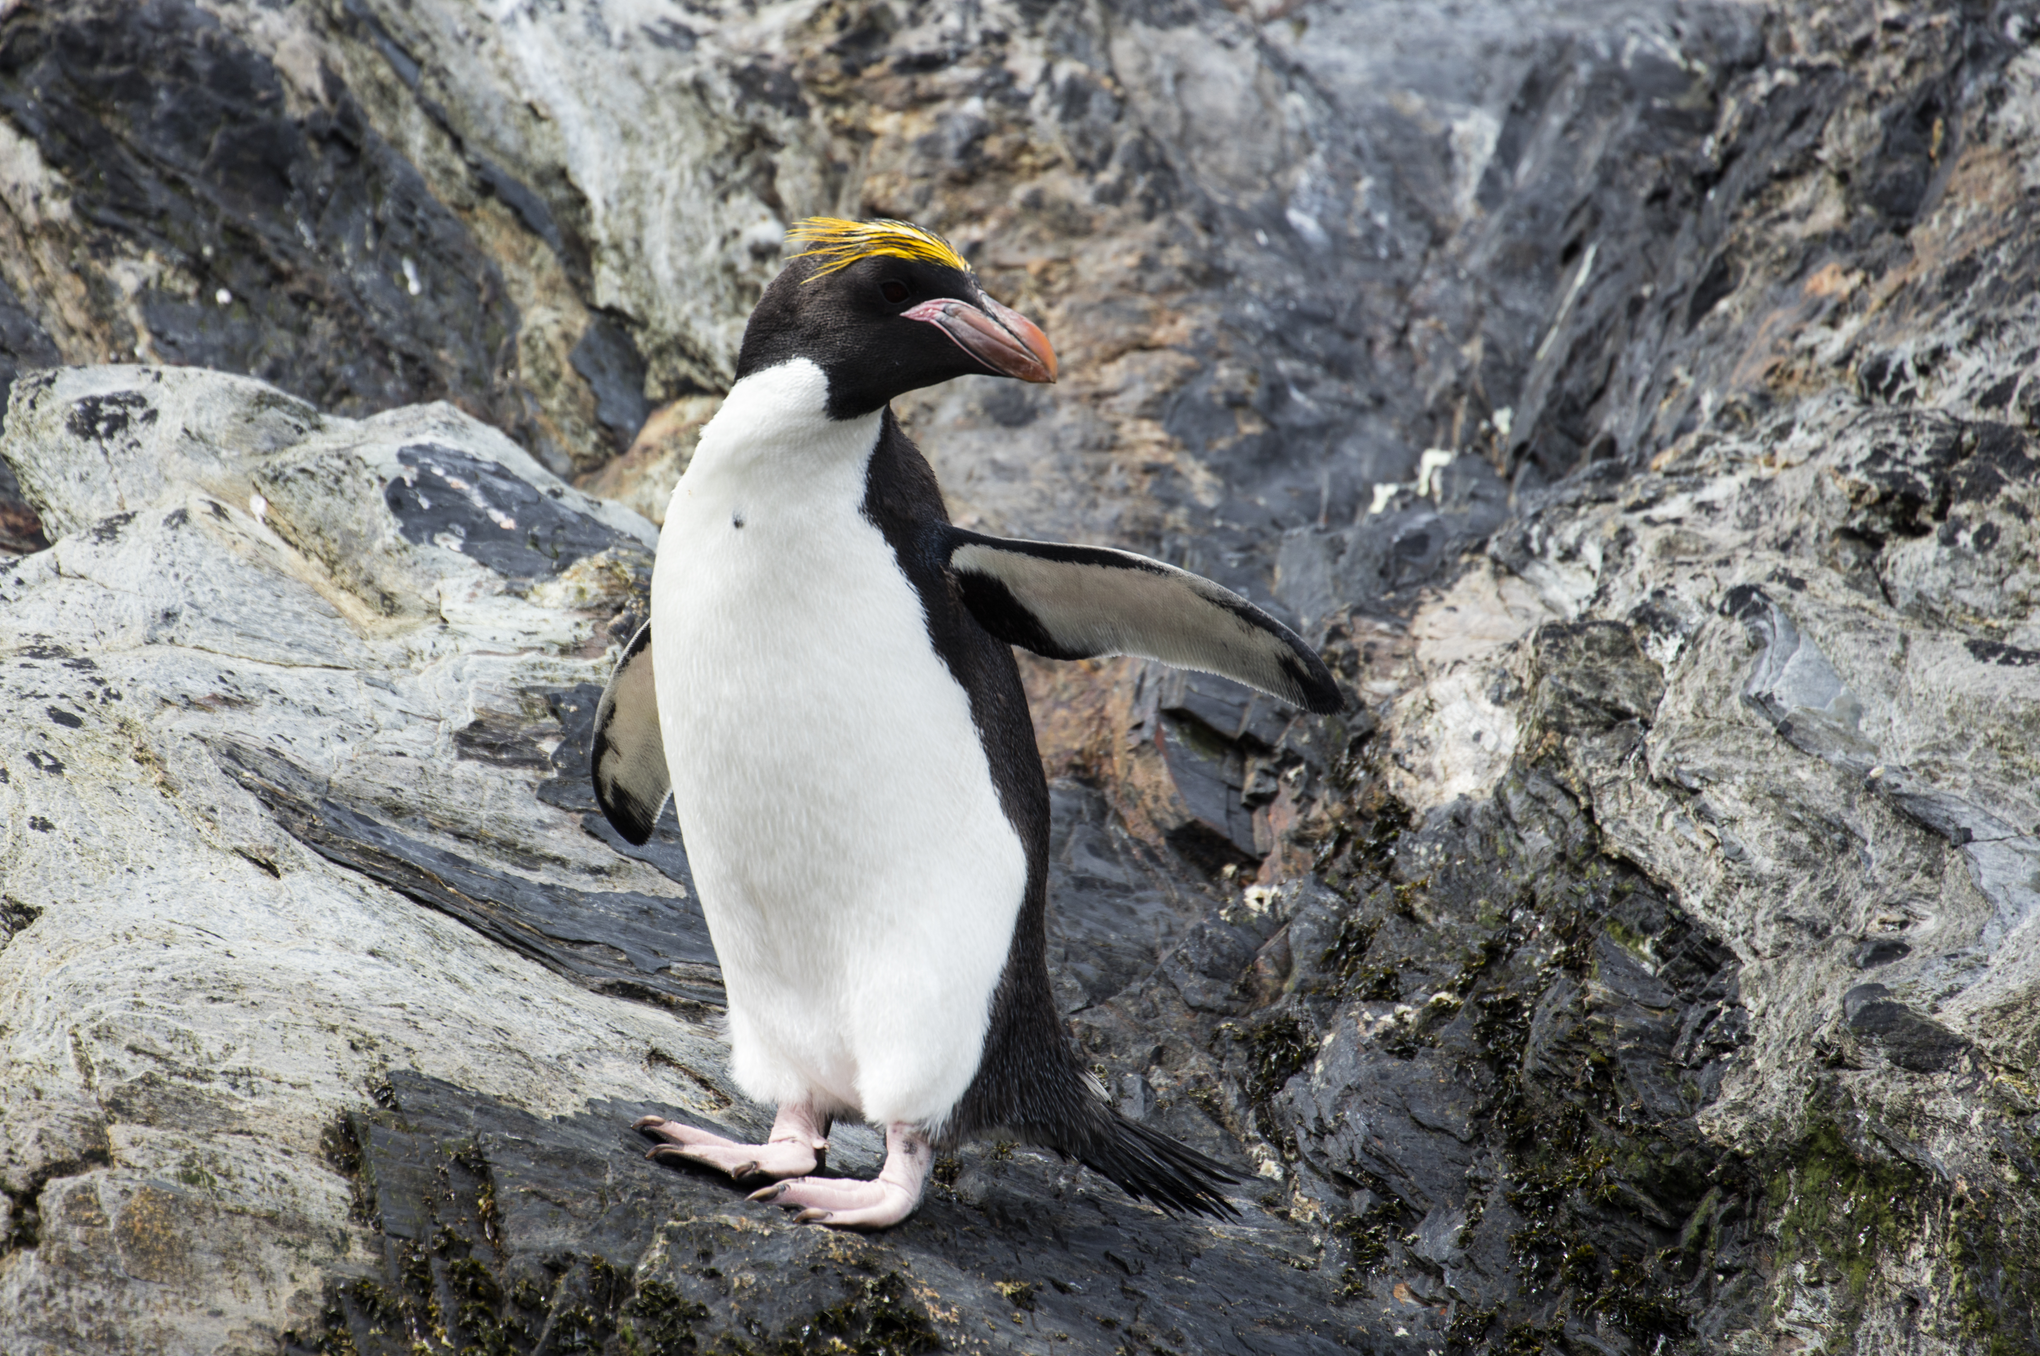

In [ ]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename='/content/test/DIV2K_valid_HR/0801.png'))

#### The Tools

We'll build and train our model with PyTorch. We'll also use torchvision, a helpful set of tools for working with images and videos in PyTorch, and scikit-learn for converting between RGB and LAB colorspces. 


In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

Now, we'll define our model in code. We'll start with the second half of the net, the upsampling layers:

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 512

    ## First half: ResNet
    resnet = models.resnet34(pretrained=True) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:8])

    ## Second half: Upsampling
    self.upsample1 = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Upsample(scale_factor=2))
    self.upsample2 = nn.Sequential(
      nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2))
    
    self.upsample3 = nn.Sequential(
      nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2))
    self.upsample4 = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2)
      
      )
    self.output = nn.Sequential(
      nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
      )
  def forward(self, input):

    result=[]
    # print(self.vgg16_bn)
    for idx,model in enumerate(self.midlevel_resnet):
        # print("in loop")
        input=model(input)
        if(idx in {2,4,5,6}):
            result.append(input)

    # Pass input through ResNet-gray to extract features
    upsample1 = self.upsample1(input)
    input = torch.cat((upsample1,result[-1]),1)
    upsample2 = self.upsample2(input)
    input = torch.cat((upsample2,result[-2]),1)
    upsample3 = self.upsample3(input)
    input = torch.cat((upsample3,result[-3]),1)
    upsample4 = self.upsample4(input)
    input = torch.cat((upsample4,result[-4]),1)
    output = self.output(input)

    # Upsample to get colors
    return output

In [ ]:
!git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git
!mv -f ./pytorch-ssim/* ./

import pytorch_ssim

fatal: destination path 'pytorch-ssim' already exists and is not an empty directory.
mv: cannot stat './pytorch-ssim/*': No such file or directory


In [ ]:
criterion = nn.MSELoss()
ssim_loss_train = pytorch_ssim.SSIM(window_size = 11)
model = ColorizationNet()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=0.0)

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

Next we define transforms for our training and validation data.

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(128), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('/content/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=32, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128)])
val_imagefolder = GrayscaleImageFolder('/content/test' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=32, shuffle=False)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count
import pytorch_ssim

def to_rgb(grayscale_input, ab_input, target,ssimsegmentation_losses, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  # print(ssim_loss)
  # sloss = ssim_loss(color_image, target)
 
  # ssim_losses.update(sloss.item(), color_image.size(0))
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch, size=0):
  model.eval()
  

  # Prepare value counters and timers
  batch_time, data_time, losses, ssim_losses = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
  ssim_loss = pytorch_ssim.SSIM(window_size = 11)

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    sloss = ssim_loss(output_ab,input_ab)
    ssim_losses.update(sloss.item(), input_gray.size(0))
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray'+str(size)+'/', 'colorized': 'outputs/color'+str(size)+'/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), output_ab[j].detach().cpu(), target[j].detach().cpu(), ssim_losses, save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg, ssim_losses.avg

In [ ]:
def train(train_loader, model, criterion, ssim_loss_train, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    # print(output_ab.shape,input_ab.shape)
    loss = criterion(output_ab, input_ab) 
    sLoss = ssim_loss_train(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))
    loss = loss + 0.001*sLoss
    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

Next, we define a training loop and we train for 100 epochs:

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  ssim_loss_train = ssim_loss_train.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
# !rm -r outputs/color256
# !rm -r outputs/gray256
# !rm -r outputs/color
# !rm -r outputs/gray
!rm -r outputs/
!mkdir outputs/
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('outputs/color64', exist_ok=True)
os.makedirs('outputs/gray64', exist_ok=True)
os.makedirs('outputs/color128', exist_ok=True)
os.makedirs('outputs/gray128', exist_ok=True)
os.makedirs('outputs/color256', exist_ok=True)
os.makedirs('outputs/gray256', exist_ok=True)
os.makedirs('outputs/color512', exist_ok=True)
os.makedirs('outputs/gray512', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 10
epochs = 64


rm: cannot remove 'outputs/': No such file or directory


In [ ]:
# Train model

loss_list = []
ssim_list = []
epoch2size = {0:(256,32) }
for epoch in range(epochs):
  # Train for one epoch, then validate

  if (epoch2size.get(epoch)):
    size = epoch2size[epoch]
    # Training
    train_transforms = transforms.Compose([transforms.RandomResizedCrop(size[0]), transforms.RandomHorizontalFlip()])
    train_imagefolder = GrayscaleImageFolder('/content/train', train_transforms)
    train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=size[1], shuffle=True)

    # Validation 
    val_transforms = transforms.Compose([transforms.Resize(size[0]), transforms.CenterCrop(size[0])])
    val_imagefolder = GrayscaleImageFolder('/content/test' , val_transforms)
    val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=size[1], shuffle=False)


  train(train_loader, model, criterion,ssim_loss_train, optimizer, epoch)
  with torch.no_grad():
    losses,ssim = validate(val_loader, model, criterion, save_images, epoch, size[0])
  print(ssim)
  loss_list.append(losses)
  ssim_list.append(ssim)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    print("NEW BEST :", losses, "EPOCH:",epoch)
    torch.save(model.state_dict(), '/content/checkpoints/model_skip_best'+str(size[0])+'.pth')

Starting training epoch 0
Epoch: [0][0/25]	Time 4.905 (4.905)	Data 4.642 (4.642)	Loss 0.3891 (0.3891)	
Finished training epoch 0


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 245 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.321 (5.321)	Loss 0.4312 (0.4312)	
Finished validation.
0.15721846461296082
NEW BEST : 0.32510733485221865 EPOCH: 0
Starting training epoch 1
Epoch: [1][0/25]	Time 4.803 (4.803)	Data 4.634 (4.634)	Loss 0.0490 (0.0490)	
Finished training epoch 1


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2178 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 26 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color

Validate: [0/4]	Time 5.404 (5.404)	Loss 0.0382 (0.0382)	
Finished validation.
0.25201905131340024
NEW BEST : 0.04115435019135475 EPOCH: 1
Starting training epoch 2
Epoch: [2][0/25]	Time 4.482 (4.482)	Data 4.314 (4.314)	Loss 0.0138 (0.0138)	
Finished training epoch 2


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1461 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 95 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 18 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 59 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 16 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Col

Validate: [0/4]	Time 5.293 (5.293)	Loss 0.0113 (0.0113)	
Finished validation.
0.34064030170440673
NEW BEST : 0.011882061176002025 EPOCH: 2
Starting training epoch 3
Epoch: [3][0/25]	Time 4.670 (4.670)	Data 4.489 (4.489)	Loss 0.0092 (0.0092)	
Finished training epoch 3


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 154 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 45 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color

Validate: [0/4]	Time 5.251 (5.251)	Loss 0.0084 (0.0084)	
Finished validation.
0.40162302017211915
NEW BEST : 0.008156831674277783 EPOCH: 3
Starting training epoch 4
Epoch: [4][0/25]	Time 4.416 (4.416)	Data 4.237 (4.237)	Loss 0.0074 (0.0074)	
Finished training epoch 4


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 200 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 60 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.283 (5.283)	Loss 0.0070 (0.0070)	
Finished validation.
0.45263940215110776
NEW BEST : 0.006497917436063289 EPOCH: 4
Starting training epoch 5
Epoch: [5][0/25]	Time 4.529 (4.529)	Data 4.360 (4.360)	Loss 0.0072 (0.0072)	
Finished training epoch 5


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 343 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 37 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.269 (5.269)	Loss 0.0067 (0.0067)	
Finished validation.
0.48288492441177366
NEW BEST : 0.006092866212129593 EPOCH: 5
Starting training epoch 6
Epoch: [6][0/25]	Time 4.624 (4.624)	Data 4.455 (4.455)	Loss 0.0053 (0.0053)	
Finished training epoch 6


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 39 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.046 (5.046)	Loss 0.0059 (0.0059)	
Finished validation.
0.5160117399692535
NEW BEST : 0.005368589013814926 EPOCH: 6
Starting training epoch 7
Epoch: [7][0/25]	Time 4.968 (4.968)	Data 4.800 (4.800)	Loss 0.0073 (0.0073)	
Finished training epoch 7


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 29 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.287 (5.287)	Loss 0.0056 (0.0056)	
Finished validation.
0.5419868922233582
NEW BEST : 0.005054919235408306 EPOCH: 7
Starting training epoch 8
Epoch: [8][0/25]	Time 4.474 (4.474)	Data 4.291 (4.291)	Loss 0.0058 (0.0058)	
Finished training epoch 8
Validate: [0/4]	Time 5.206 (5.206)	Loss 0.0053 (0.0053)	
Finished validation.
0.5610003876686096
NEW BEST : 0.004809157513082027 EPOCH: 8
Starting training epoch 9
Epoch: [9][0/25]	Time 4.678 (4.678)	Data 4.496 (4.496)	Loss 0.0063 (0.0063)	
Finished training epoch 9


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 32 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.291 (5.291)	Loss 0.0052 (0.0052)	
Finished validation.
0.5800084614753723
NEW BEST : 0.004657653421163559 EPOCH: 9
Starting training epoch 10
Epoch: [10][0/25]	Time 4.368 (4.368)	Data 4.200 (4.200)	Loss 0.0053 (0.0053)	
Finished training epoch 10


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.298 (5.298)	Loss 0.0054 (0.0054)	
Finished validation.
0.5901654493808747
Starting training epoch 11
Epoch: [11][0/25]	Time 4.427 (4.427)	Data 4.258 (4.258)	Loss 0.0043 (0.0043)	
Finished training epoch 11
Validate: [0/4]	Time 5.272 (5.272)	Loss 0.0049 (0.0049)	
Finished validation.
0.6057931780815125
NEW BEST : 0.004390086680650711 EPOCH: 11
Starting training epoch 12
Epoch: [12][0/25]	Time 4.688 (4.688)	Data 4.520 (4.520)	Loss 0.0039 (0.0039)	
Finished training epoch 12
Validate: [0/4]	Time 5.237 (5.237)	Loss 0.0049 (0.0049)	
Finished validation.
0.615953049659729
Starting training epoch 13
Epoch: [13][0/25]	Time 4.777 (4.777)	Data 4.597 (4.597)	Loss 0.0035 (0.0035)	
Finished training epoch 13
Validate: [0/4]	Time 5.252 (5.252)	Loss 0.0045 (0.0045)	
Finished validation.
0.6297151637077332
NEW BEST : 0.004103308357298374 EPOCH: 13
Starting training epoch 14
Epoch: [14][0/25]	Time 4.526 (4.526)	Data 4.346 (4.346)	Loss 0.0039 (0.0039)	
Finished training epoch 14


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.278 (5.278)	Loss 0.0047 (0.0047)	
Finished validation.
0.6358067989349365
Starting training epoch 15
Epoch: [15][0/25]	Time 4.646 (4.646)	Data 4.478 (4.478)	Loss 0.0038 (0.0038)	
Finished training epoch 15
Validate: [0/4]	Time 5.334 (5.334)	Loss 0.0045 (0.0045)	
Finished validation.
0.6501835441589355
NEW BEST : 0.004045481719076633 EPOCH: 15
Starting training epoch 16
Epoch: [16][0/25]	Time 5.012 (5.012)	Data 4.844 (4.844)	Loss 0.0047 (0.0047)	
Finished training epoch 16
Validate: [0/4]	Time 5.010 (5.010)	Loss 0.0044 (0.0044)	
Finished validation.
0.6601099276542663
NEW BEST : 0.00394225686788559 EPOCH: 16
Starting training epoch 17
Epoch: [17][0/25]	Time 4.396 (4.396)	Data 4.215 (4.215)	Loss 0.0036 (0.0036)	
Finished training epoch 17
Validate: [0/4]	Time 5.172 (5.172)	Loss 0.0043 (0.0043)	
Finished validation.
0.6656620216369629
NEW BEST : 0.003885350190103054 EPOCH: 17
Starting training epoch 18
Epoch: [18][0/25]	Time 4.626 (4.626)	Data 4.451 (4.451)	Loss 0.0

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.334 (5.334)	Loss 0.0043 (0.0043)	
Finished validation.
0.6758236885070801
Starting training epoch 20
Epoch: [20][0/25]	Time 4.645 (4.645)	Data 4.477 (4.477)	Loss 0.0038 (0.0038)	
Finished training epoch 20
Validate: [0/4]	Time 5.315 (5.315)	Loss 0.0040 (0.0040)	
Finished validation.
0.6858466672897339
NEW BEST : 0.0037468377873301506 EPOCH: 20
Starting training epoch 21
Epoch: [21][0/25]	Time 4.475 (4.475)	Data 4.305 (4.305)	Loss 0.0042 (0.0042)	
Finished training epoch 21


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.188 (5.188)	Loss 0.0043 (0.0043)	
Finished validation.
0.6923457551002502
Starting training epoch 22
Epoch: [22][0/25]	Time 4.609 (4.609)	Data 4.433 (4.433)	Loss 0.0032 (0.0032)	
Finished training epoch 22
Validate: [0/4]	Time 5.323 (5.323)	Loss 0.0041 (0.0041)	
Finished validation.
0.6932752537727356
Starting training epoch 23
Epoch: [23][0/25]	Time 4.301 (4.301)	Data 4.124 (4.124)	Loss 0.0038 (0.0038)	
Finished training epoch 23
Validate: [0/4]	Time 5.199 (5.199)	Loss 0.0039 (0.0039)	
Finished validation.
0.6999732422828674
NEW BEST : 0.0035307797975838184 EPOCH: 23
Starting training epoch 24
Epoch: [24][0/25]	Time 4.577 (4.577)	Data 4.409 (4.409)	Loss 0.0031 (0.0031)	
Finished training epoch 24


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 17 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.084 (5.084)	Loss 0.0040 (0.0040)	
Finished validation.
0.7018118047714234
Starting training epoch 25
Epoch: [25][0/25]	Time 4.454 (4.454)	Data 4.286 (4.286)	Loss 0.0031 (0.0031)	
Finished training epoch 25
Validate: [0/4]	Time 5.256 (5.256)	Loss 0.0038 (0.0038)	
Finished validation.
0.7074084424972534
NEW BEST : 0.003491785451769829 EPOCH: 25
Starting training epoch 26
Epoch: [26][0/25]	Time 4.766 (4.766)	Data 4.596 (4.596)	Loss 0.0037 (0.0037)	
Finished training epoch 26
Validate: [0/4]	Time 5.310 (5.310)	Loss 0.0038 (0.0038)	
Finished validation.
0.713776273727417
NEW BEST : 0.003481848947703838 EPOCH: 26
Starting training epoch 27
Epoch: [27][0/25]	Time 4.897 (4.897)	Data 4.716 (4.716)	Loss 0.0040 (0.0040)	
Finished training epoch 27
Validate: [0/4]	Time 5.276 (5.276)	Loss 0.0040 (0.0040)	
Finished validation.
0.7155137491226197
Starting training epoch 28
Epoch: [28][0/25]	Time 4.536 (4.536)	Data 4.355 (4.355)	Loss 0.0035 (0.0035)	
Finished training epoch 28
V

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 35 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/4]	Time 5.315 (5.315)	Loss 0.0038 (0.0038)	
Finished validation.
0.7429910945892334
Starting training epoch 38
Epoch: [38][0/25]	Time 4.591 (4.591)	Data 4.422 (4.422)	Loss 0.0027 (0.0027)	
Finished training epoch 38
Validate: [0/4]	Time 5.165 (5.165)	Loss 0.0038 (0.0038)	
Finished validation.
0.7464650511741638
Starting training epoch 39
Epoch: [39][0/25]	Time 4.532 (4.532)	Data 4.354 (4.354)	Loss 0.0031 (0.0031)	
Finished training epoch 39
Validate: [0/4]	Time 5.160 (5.160)	Loss 0.0037 (0.0037)	
Finished validation.
0.7448077893257141
NEW BEST : 0.0033016048930585382 EPOCH: 39
Starting training epoch 40
Epoch: [40][0/25]	Time 4.566 (4.566)	Data 4.383 (4.383)	Loss 0.0030 (0.0030)	
Finished training epoch 40
Validate: [0/4]	Time 5.378 (5.378)	Loss 0.0038 (0.0038)	
Finished validation.
0.7497152733802795
Starting training epoch 41
Epoch: [41][0/25]	Time 4.568 (4.568)	Data 4.400 (4.400)	Loss 0.0022 (0.0022)	
Finished training epoch 41
Validate: [0/4]	Time 5.164 (5.164)	Loss 0

<Figure size 432x288 with 0 Axes>

In [ ]:
import math
def psnr(mse):
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse)) if mse > 0 else -1

psnr_list = [psnr(x) for x in loss_list]

metrics = {}
metrics['psnr'] = psnr_list
metrics['mse'] = loss_list
metrics['ssim'] = ssim_list
metrics

{'mse': [0.32510733485221865,
  0.04115435019135475,
  0.011882061176002025,
  0.008156831674277783,
  0.006497917436063289,
  0.006092866212129593,
  0.005368589013814926,
  0.005054919235408306,
  0.004809157513082027,
  0.004657653421163559,
  0.004885790050029755,
  0.004390086680650711,
  0.00443563237786293,
  0.004103308357298374,
  0.004106179736554623,
  0.004045481719076633,
  0.00394225686788559,
  0.003885350190103054,
  0.004009692594408989,
  0.003917004987597466,
  0.0037468377873301506,
  0.003793578278273344,
  0.003772386945784092,
  0.0035307797975838184,
  0.0036671320348978043,
  0.003491785451769829,
  0.003481848947703838,
  0.003499176166951656,
  0.0035513795912265776,
  0.0036357324942946434,
  0.0034116068854928017,
  0.0035991638340055945,
  0.0034557740576565267,
  0.003536946251988411,
  0.003420711476355791,
  0.0033631628938019277,
  0.0035734019801020624,
  0.0034232407063245775,
  0.003519333638250828,
  0.0033016048930585382,
  0.0033742645382881164,


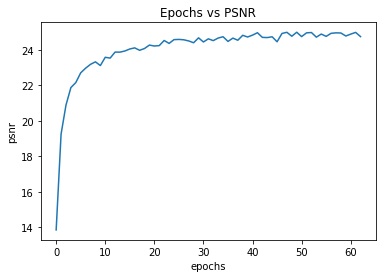

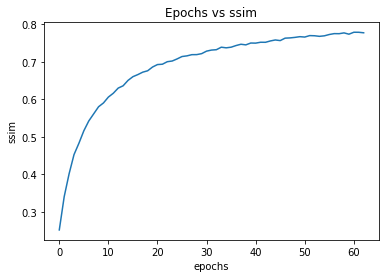

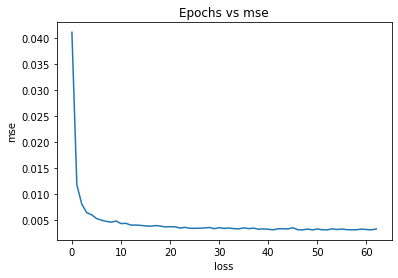

In [ ]:
import matplotlib.pyplot as plt

plt.plot(psnr_list[1:])
plt.xlabel("epochs")
plt.ylabel("psnr")
plt.title("Epochs vs PSNR")
plt.show()

plt.plot(ssim_list[1:])
plt.xlabel("epochs")
plt.ylabel("ssim")
plt.title("Epochs vs ssim")
plt.show()

plt.plot(loss_list[1:])
plt.xlabel("loss")
plt.ylabel("mse")
plt.title("Epochs vs mse")
plt.show()